Imports

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import torch
import os

Carrega MiDaS

In [93]:
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
midas.to('cpu')
midas.eval()

Using cache found in C:\Users\980166/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\980166/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

Entrada pipeline

In [94]:
transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = transforms.small_transform

Using cache found in C:\Users\980166/.cache\torch\hub\intel-isl_MiDaS_master


Usa a rede neural para aplicar profundidade na imagem

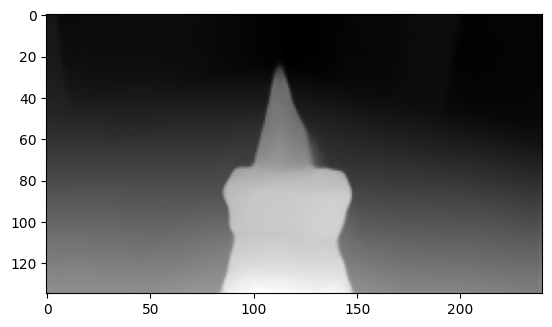

Saved uploads\uploaded_image_map.png
uploaded_image.png


In [95]:
# Diretório onde as imagens são armazenadas
image_folder = 'uploads'
image_filename = 'uploaded_image.png'  # Substitua pelo nome da imagem que você deseja processar

# Carrega a imagem
image_path = os.path.join(image_folder, image_filename)
frame = cv2.imread(image_path)

# Pré-processa a imagem e obtém a estimativa de profundidade
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
imgbatch = transform(img).to('cpu')

with torch.no_grad():
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

    output = prediction.cpu().numpy()
    output = (output - output.min()) / (output.max() - output.min())
    output = (255 * output).astype(np.uint8)

plt.imshow(output, cmap='gray')
plt.pause(0.00001)

# Salvar a imagem de saída
output_filename = os.path.splitext(image_filename)[0] + "_map.png"
output_path = os.path.join(image_folder, output_filename)
cv2.imwrite(output_path, output)
print(f'Saved {output_path}')
print(image_filename)

Carrega a imagem

In [96]:
img = cv2.imread('uploads/uploaded_image_map.png',
                 cv2.IMREAD_GRAYSCALE)

deubom = False

if img is None:
    print("Imagem não carregada.")
else:
    deubom = True
    print("Imagem carregada.")

Imagem carregada.


Picos Positivos: [92]
Picos Negativos: [145]
Obstáculos: [(92, 145, 185.23076923076925)]
Obstáculos filtrados: [(92, 145, 185.23076923076925)]


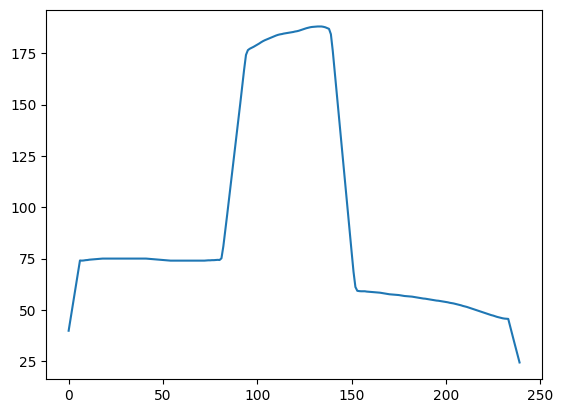

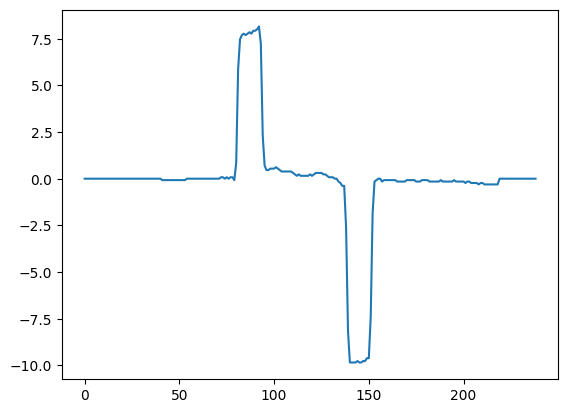

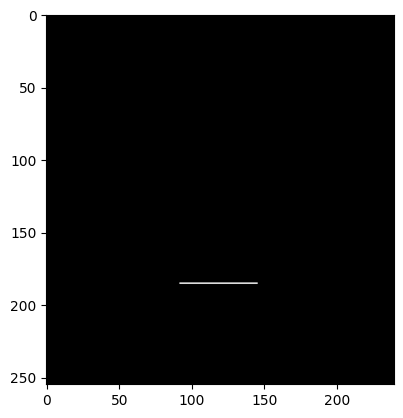

Mapa aéreo salvo como 'mapa_aereoDois.png'


In [97]:
linha_central = 80 #linha principal do espectro de intensidade do pixel

if deubom:
    x = img[linha_central, :]

    window_size = 13 
    x = np.convolve(x, np.ones(window_size) / window_size, 'same')
    plt.plot(x)

    # segunda derivada da linha central da imagem
    dx = np.diff(x)
    dx[:20] = 0
    dx[-20:]= 0
    
    plt.figure()
    plt.plot(dx)

    # picos positivos
    pks_positivos = []
    y_values_positivos = []
    while (np.max(dx) > 2.5) and len(pks_positivos) < 10:
        pos = np.argmax(dx)
        pks_positivos.append(pos)
        y_values_positivos.append(dx[pos])
        lo, hi = max(0, pos - 50), min(len(x), pos + 50)
        dx[lo:hi] = 0
    print("Picos Positivos:", pks_positivos)

    # picos negativos
    dx_negativo = -dx
    pks_negativos = []
    while (np.max(dx_negativo) > 2.5) and len(pks_negativos) < 10:
        pos = np.argmax(dx_negativo)
        pks_negativos.append(pos)
        lo, hi = max(0, pos - 50), min(len(x), pos + 50)
        dx_negativo[lo:hi] = 0
    print("Picos Negativos:", pks_negativos)

    # Crie a tupla de obstáculos
    if len(pks_positivos) > 0 or len(pks_negativos) > 0:

        if len(pks_positivos) == 0:
            pks_positivos.append(0)

        if len(pks_negativos) == 0:
            pks_negativos.append(len(dx))

        if pks_negativos[0] < pks_positivos[0]:
            pks_positivos = [0] + pks_positivos

        if pks_negativos[-1] < pks_positivos[-1]:
            pks_negativos = pks_negativos + [len(dx)]

        
        if len(pks_positivos) != len(pks_negativos):
            print("erro", pks_positivos, pks_negativos, len(dx))
        
    mean_x = [(a+b)//2 for a, b in zip(pks_positivos, pks_negativos)]
    y_values_positivos = [x[c] for c in mean_x]
    obstaculos = list(
        zip(pks_positivos, pks_negativos, y_values_positivos))
    print("Obstáculos:", obstaculos)

    # Filtrar obstáculos com base nos critérios
    obstaculos_filtrados = [
        obstaculo for obstaculo in obstaculos if obstaculo[0] >= 5 or obstaculo[1] <= 235]
    print("Obstáculos filtrados:", obstaculos_filtrados)

   # Define limites mínimos para altura e diferença entre início e fim de obstáculos
    limite_altura_minima = 126
    limite_diferenca_x = 10

    # Define as dimensões do mapa aéreo (ajuste conforme necessário)
    largura_mapa = 240
    altura_mapa = 255

    # Cria uma matriz para representar o mapa aéreo
    mapa_aereo = np.zeros((altura_mapa, largura_mapa))

    # Preenche o mapa aéreo com os obstáculos significativos
    for obstaculo in obstaculos_filtrados:
        inicio_x, fim_x, altura_y = obstaculo
        altura_y = int(altura_y)
        inicio_x = max(0, inicio_x)
        fim_x = min(largura_mapa - 1, fim_x)
        if altura_y >= altura_mapa:
            altura_y = altura_mapa - 1
        for x in range(inicio_x, fim_x + 1):
            mapa_aereo[altura_y, x] = 1

    plt.figure()
    plt.imshow(mapa_aereo, cmap='gray')
    plt.show()

    nome_arquivo_saida = 'mapa_aereoDois.png'
    cv2.imwrite(nome_arquivo_saida, mapa_aereo * 255)
    print(f"Mapa aéreo salvo como '{nome_arquivo_saida}'")



Carrega o mapa aereo

In [98]:
aereoMap = cv2.imread('mapa_aereoDois.png', cv2.IMREAD_GRAYSCALE)

In [99]:
# dilatação dos obstáculos
kernel = np.ones((200, 200), np.uint8)
img_dilated = cv2.dilate(aereoMap, kernel, iterations=1)

# centro da base do eixo X
start_node = (aereoMap.shape[0] - 1, aereoMap.shape[1] // 2)

# destino
goal_node = (50, 800)

Heuristica


In [100]:
def heuristic(node, goal, img):  # distância euclidiana
    penalty = 1.0
    distance = np.sqrt((node[0] - goal[0]) ** 2 + (node[1] - goal[1]) ** 2)
    penalty_term = penalty * img[node[0], node[1]] / 255.0
    return distance + penalty_term

In [101]:
def is_valid(node, img):  # verifica limites do mapa e se não é um obstáculo
    if (
        0 <= node[0] < img.shape[0] and
        0 <= node[1] < img.shape[1] and
        img[node[0], node[1]] == 0
    ):
        return True
    return False

Algoritmo A Estrela


In [102]:
def astar(img, start, goal):
    open_set = PriorityQueue()
    open_set.put((0, start))
    came_from = {}
    g_score = {node: float('inf') for node in np.ndindex(img.shape)}
    g_score[start] = 0
    f_score = {node: float('inf') for node in np.ndindex(img.shape)}
    f_score[start] = heuristic(start, goal, img)

    while not open_set.empty():
        _, current = open_set.get()

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        for neighbor in [(current[0] - 1, current[1]), (current[0] + 1, current[1]),
                         (current[0], current[1] - 1), (current[0], current[1] + 1)]:
            if is_valid(neighbor, img):
                tentative_g_score = g_score[current] + 1
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + \
                        heuristic(neighbor, goal, img)
                    open_set.put((f_score[neighbor], neighbor))

    return None

Identificar o objeto vermelho

In [103]:
image_path = 'uploads/uploaded_image.png'  
imgColor = cv2.imread(image_path)

# Converte em HSV
hsv_img = cv2.cvtColor(imgColor, cv2.COLOR_BGR2HSV)

lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

# máscara para pixels vermelhos
mask = cv2.inRange(hsv_img, lower_red, upper_red)


Encontrar o centro do objeto vermelho

In [104]:
# contornos na máscara
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Encontra o maior contorno
if len(contours) > 0:
    largest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest_contour)

    # Calcula as coordenadas do centro do objeto vermelho
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        center_x, center_y = -1, -1

    if center_x != -1 and center_y != -1:
        goal_node = (center_y, center_x) 

In [105]:
path = astar(img_dilated, start_node, goal_node)

Desenha caminho


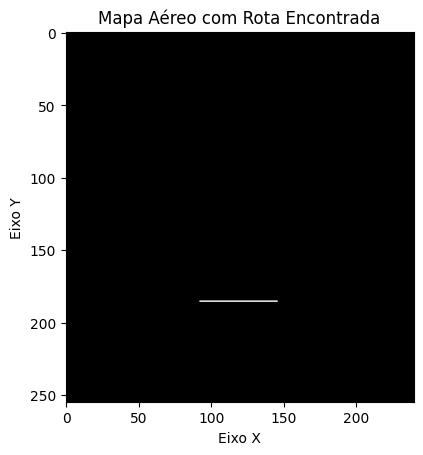

In [106]:
if path:
    path_points = np.array(path)

    plt.plot(path_points[:, 1], path_points[:, 0], 'r-', linewidth=2)

    n = 70
    selected_points = path_points[::n]

    plt.plot(selected_points[:, 1], selected_points[:, 0], 'go', markersize=3)

plt.imshow(aereoMap, cmap='gray')
plt.title('Mapa Aéreo com Rota Encontrada')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.show()